# Data augmentation Experiments

For this project we will implement different types of data augmentations as well as custom data augmentation

## Imports


In [ ]:
# GradScaler is used for mixed precision training in PyTorch.
import os
import sys
from pathlib import Path

import albumentations as A
import torch
import torchvision.transforms.functional as F
import tqdm
from torch.amp import GradScaler

sys.path.append(str(Path().resolve().parent / "src"))

Classes and augmentation functions

In [ ]:
# Import necessary functions and classes
from un_detector.data.datasets import HazmatDataset  # type: ignore
from un_detector.data.augmentation import (  # type: ignore
    get_augmented_transform,
    visualize_augmentations,
    generate_augmented_images, 
    visualize_weather_augmentations
)
from un_detector.utils.file_io import save_json, tensor_to_list  # type: ignore

c:\Users\ewald\Documents\un-number-detection\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ewald\Documents\un-number-detection\.venv\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Faster R-CNN Data Augmentations

In [9]:
# Initialize the GradScaler for mixed precision training
scaler = GradScaler()

In [ ]:
# Define your augmentations
augmentations = get_augmented_transform(train=True)

# Create directories to save augmented data
base_dir = 'data/processed/prorail_coco_format/augmented_data'
augmented_images_dir = base_dir + '/images'
# Define the path for augmented annotations
augmented_annotations_file = base_dir + '/annotations/instances_aug.json'
os.makedirs(augmented_images_dir, exist_ok=True)

# Remove all files in the augmented_images_dir
if os.path.exists(augmented_images_dir):
    for file in os.listdir(augmented_images_dir):
        file_path = os.path.join(augmented_images_dir, file)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # Remove the file or symlink
            elif os.path.isdir(file_path):
                os.rmdir(file_path)  # Remove the directory (if empty)
        except Exception as e:
            print(f"Error deleting file {file_path}: {e}")
else:
    print(f"Directory {augmented_images_dir} does not exist.")


# Check if the augmented annotations file exists, if not create it
if os.path.exists(augmented_annotations_file):
    os.remove(augmented_annotations_file)  # Delete the existing file
    print(f"Deleted existing annotations file: {augmented_annotations_file}")

In [ ]:
# Create a default structure for the augmented annotations
categories_list = [
    {"id": 1, "name": "hazmat code"}
]

# Load the original dataset, we use train in this instance to apply augmentations 
# but we will not use it for training and you might actually want to concat the train, validation and test datasets for this use case.
original_dataset = HazmatDataset(
    root='data/processed/prorail_coco_format/formatted_data/train',
    ann_file='annotations/instances_train.json',
    transforms=augmentations,
    train=False
)

augmented_annotations = {
    'images': [],
    'annotations': [],
    'categories': categories_list
}
save_json(augmented_annotations, augmented_annotations_file)
print(f"Created new annotations file: {augmented_annotations_file}")


# Counter for image and annotation IDs
img_id = len(augmented_annotations['images'])
ann_id = len(augmented_annotations['annotations'])

# Number of augmented images to create
num_images_to_generate = 1000  # Set this to your desired limit

# Iterate through the dataset with progress tracking
generated_count = 0  # Counter for how many images we have generated
for idx in tqdm(range(len(original_dataset)), desc="Augmenting dataset"):
    if generated_count >= num_images_to_generate:
        break  # Stop when the desired number of augmented images is created
    
    img, target = original_dataset[idx]
    
    # Apply augmentations
    aug_img, aug_target = augmentations(img, target)
    # Save augmented image
    aug_img_path = os.path.join(augmented_images_dir, f'aug_{img_id}.jpg')
    if isinstance(aug_img, torch.Tensor):
        aug_img = F.to_pil_image(aug_img)
    aug_img.save(aug_img_path)
    
    # Update image annotation
    augmented_annotations['images'].append({
        'id': img_id,
        'file_name': os.path.basename(aug_img_path),
        'width': aug_img.width,
        'height': aug_img.height
    })
    
    # Update annotations
    for box, label in zip(aug_target['boxes'], aug_target['labels']):
        augmented_annotations['annotations'].append({
            'id': ann_id,
            'image_id': img_id,
            'category_id': label.item(),
            'bbox': [
                box[0].item(), box[1].item(), 
                box[2].item() - box[0].item(), 
                box[3].item() - box[1].item()
            ],
            'area': (box[2] - box[0]) * (box[3] - box[1]),
            'iscrowd': 0
        })
        ann_id += 1

    # Update the image and annotation IDs
    img_id += 1
    generated_count += 1  # Increase the generated image counter

# Convert tensors to lists before saving the annotations
augmented_annotations = tensor_to_list(augmented_annotations)

# Save augmented annotations
save_json(augmented_annotations, augmented_annotations_file)

print(f"Generated {generated_count} augmented images.")

In [ ]:
visualize_augmentations(augmented_images_dir, augmented_annotations_file, num_images=5)

# YOLOv11
For Yolov11 we can use the standard ultralytics library for data augmentation

# Weather Augmentations
This code is used to augment images with weather conditions, however the annotation algorithm has not been written yet, therefore this can only be used for human evaluation (e.g. visualising how the model performs under weather augmentations)

In [ ]:
import os
import random
from PIL import Image
from typing import Union
import cv2


In [ ]:
augmentation_presets = {
    'rain': A.RandomRain(
        brightness_coefficient=0.9,  # Slightly darker rain
        drop_width=3, # Thicker rain drops
        blur_value=5, # Stronger blur effect
        p=1, # Always apply rain
        drop_length=20), # Longer rain streaks
    'sun_flare': A.RandomSunFlare(
        flare_roi=(0, 0, 1, 0.5), # Flare in the upper half of the image
        angle_lower=0.5, # Angle of tronger sun flare
        p=1), # Always apply sun flare
    'shadow': A.RandomShadow(
        num_shadows_lower=10, # More shadows
        num_shadows_upper=15, 
        shadow_dimension=8, # Larger and darker shadows
        shadow_roi=(0, 0, 1, 1), # Shadows across the entire image
        p=1), # Always apply shadows
    'fog': A.RandomFog(p=1), # Always apply fog
    
    # 'snow': A.RandomSnow(p=1) # Snow is really unrealistic and not recommended
}

Generate the augmentations

In [ ]:
# loop over each file in the input directory and apply the augmentation
count = 0
input_directory = '../data/processed/prorail_coco_format/formatted_data/train/images'
for file_name in os.listdir(input_directory):
    if file_name.endswith('.jpg') or file_name.endswith('.png') or file_name.endswith('.jpeg') or file_name.endswith('.bmp') or file_name.endswith('.tiff') or file_name.endswith('.webp') or file_name.endswith('.tif'):
        count += 1
        types = ['rain', 'sun_flare', 'shadow', 'fog']
        # first do rain then sun_flare, shadow and fog
        for augmentation in types:
            input_image_path = os.path.join(input_directory, file_name)
            output_dir = f'../data/processed/prorail_coco_format/augmented_data/{augmentation}'
            generate_augmented_images(
                input_image_path=input_image_path,
                output_dir=output_dir,
                output_filename_base= str(count),
                augmentation=augmentation,
                seed=42  # Same seed = same augmentations
            )
    

Visualise the augmentations

Augmented image for sun_flare not found: ../data/augmented_images/sun_flare\1.jpg


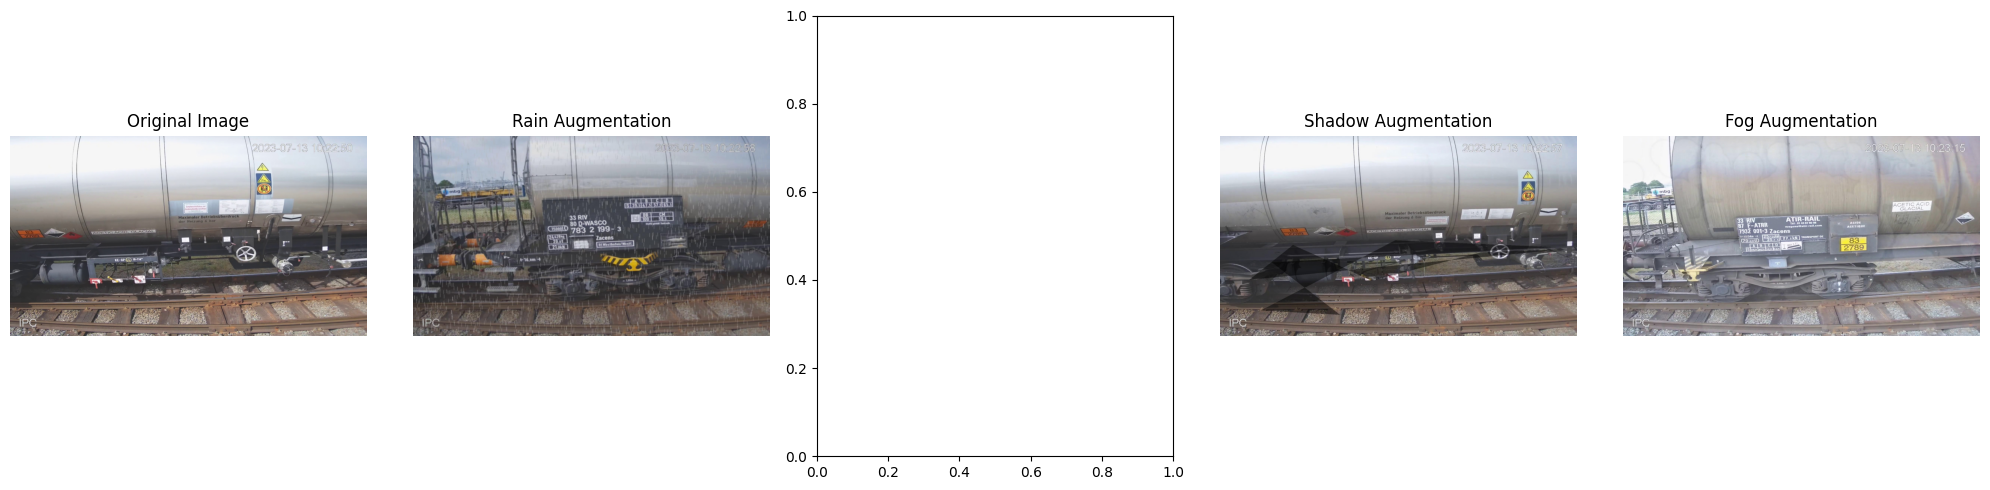

Augmented image for sun_flare not found: ../data/augmented_images/sun_flare\1.jpg


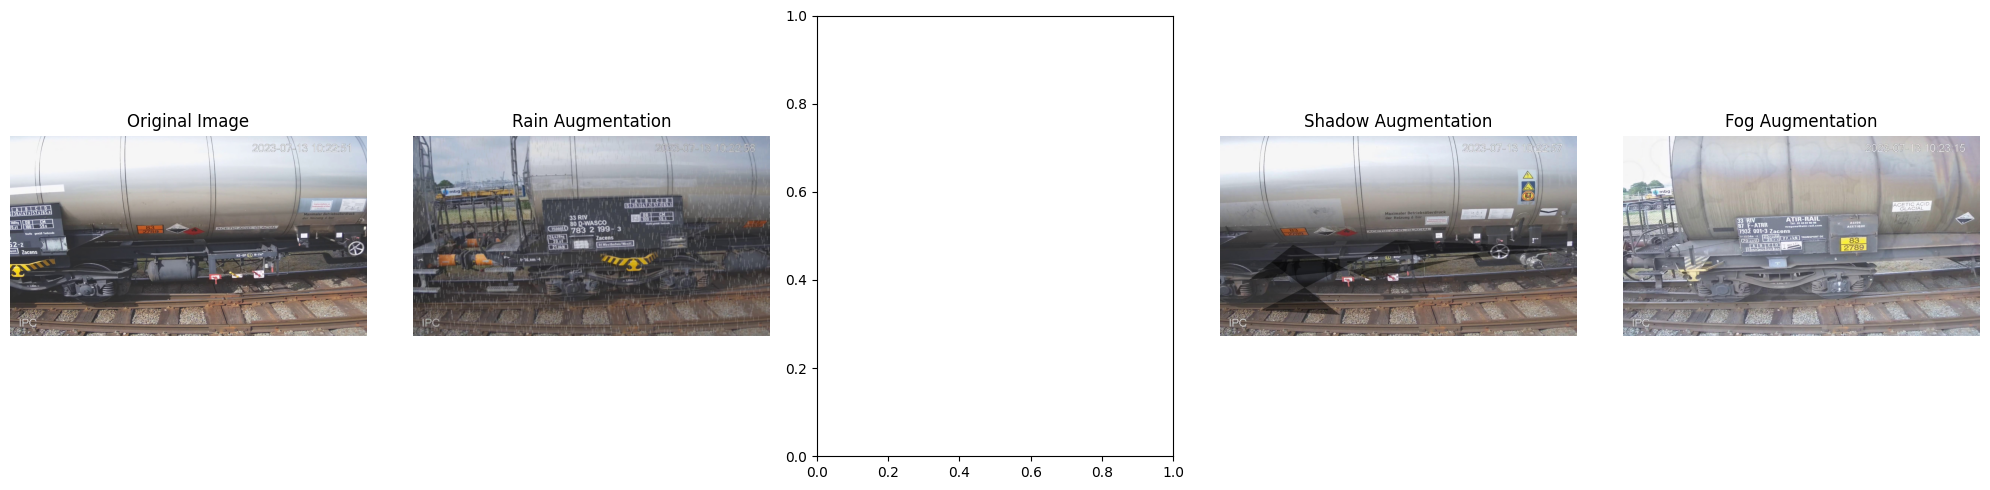

Augmented image for sun_flare not found: ../data/augmented_images/sun_flare\1.jpg


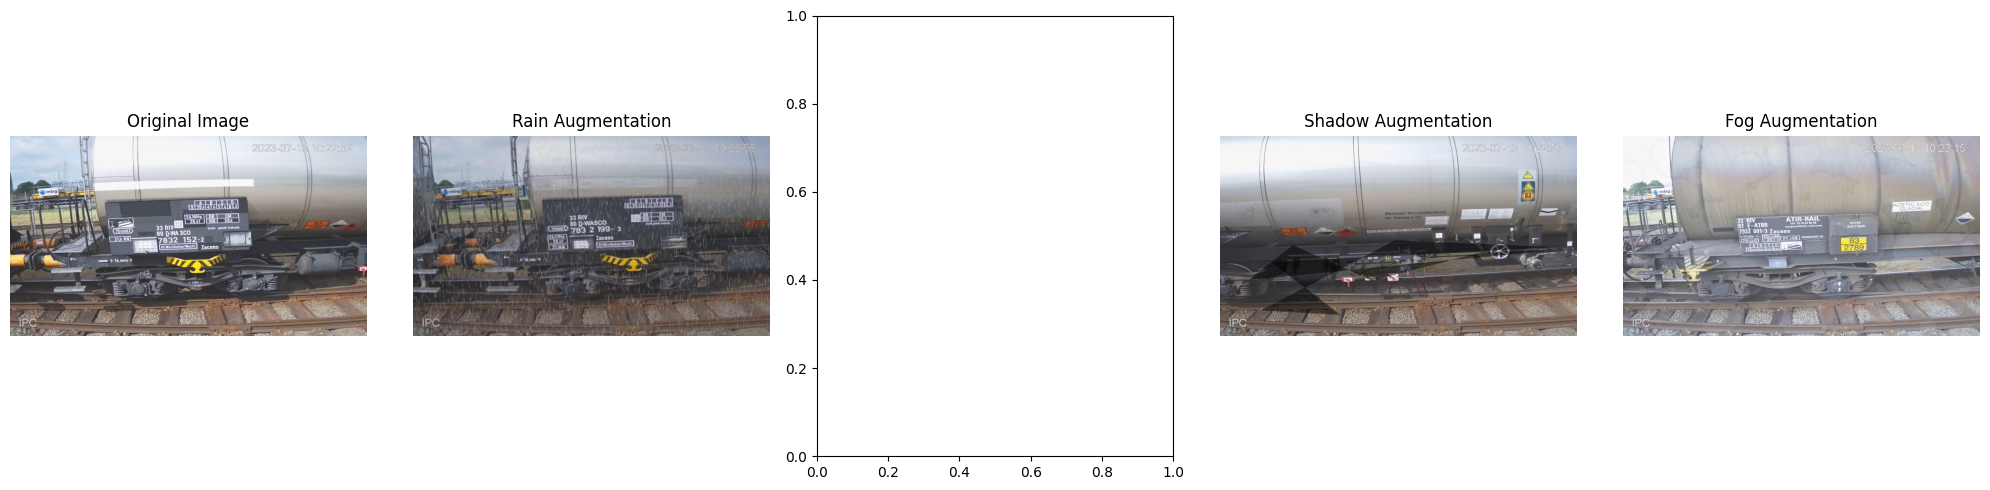

Augmented image for sun_flare not found: ../data/augmented_images/sun_flare\1.jpg


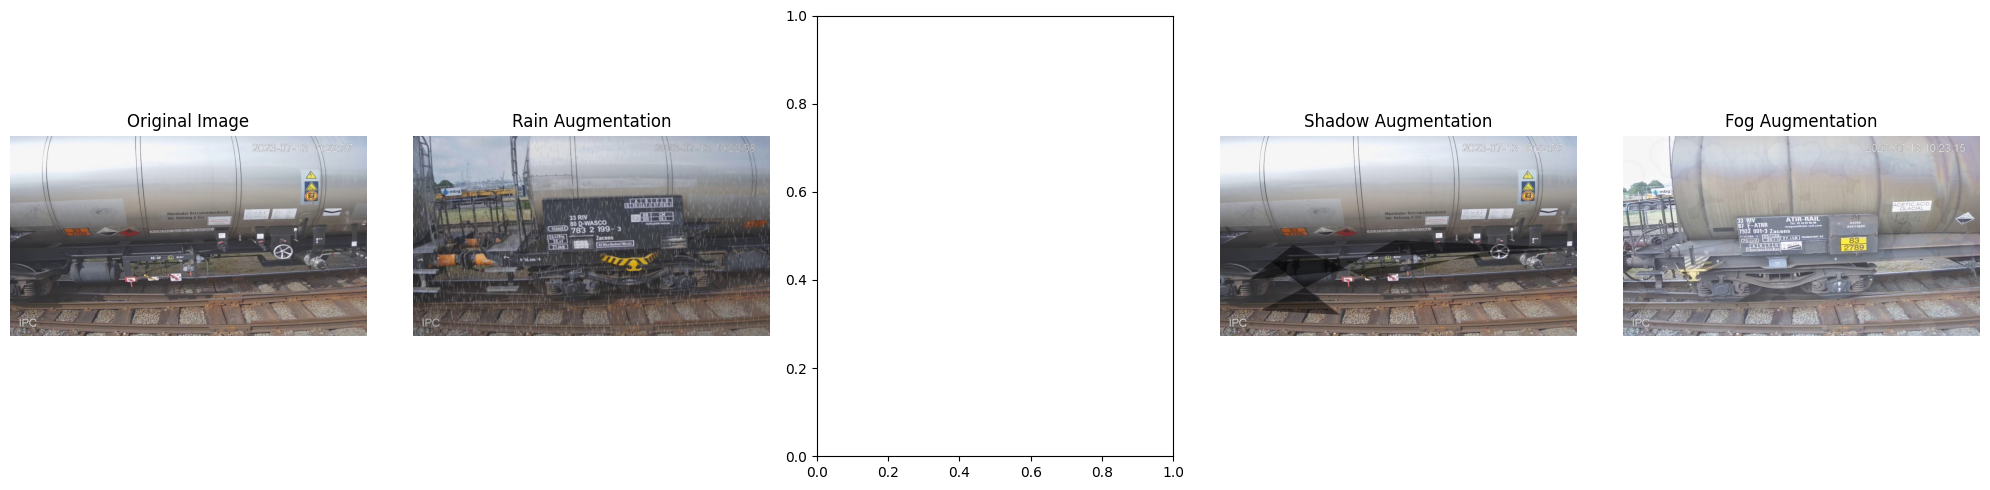

Augmented image for sun_flare not found: ../data/augmented_images/sun_flare\1.jpg


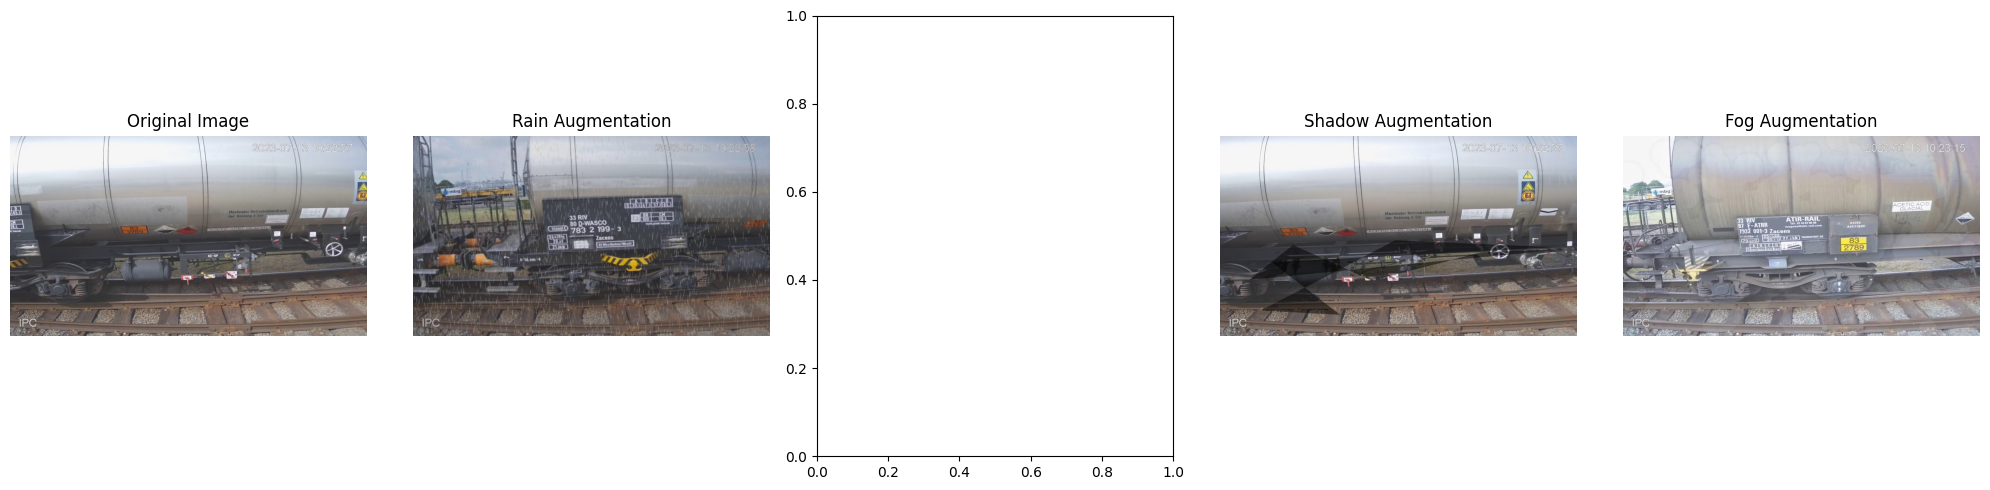

In [ ]:
augmentations_dir = "../data/processed/prorail_coco_format/augmented_data/"

visualize_weather_augmentations(input_directory, augmentations_dir, num_images=5)